In [1]:
from keras.utils import np_utils
import numpy as np
from matplotlib import pyplot
import seaborn as sns
import shutil
import importlib

import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Reshape
from keras.regularizers import l2
from keras import optimizers
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input


from sklearn.datasets import load_files
import pandas as pd
pd.set_option("display.max_colwidth", 75)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

Using TensorFlow backend.
/home/tutysara/anaconda2/envs/dog-project/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from bcolzutils import *
from util import *

In [10]:
alpha = 1
dropout=1e-3
num_classes = 3
lr=1e-3
momentum=0.9
weight_decay = 1e-5
num_classes = 3
percent = 0.005
batch_size = 256

basedir="/media/hdd/datastore/t4sa"

valid_name = basedir + '/valid_data'
test_name = basedir + '/test_data'
train_name = basedir +'/train_data' 

bnf_valid_name = basedir +'/bottleneck_features_mobilenet_valid'
bnf_test_name = basedir +'/bottleneck_features_mobilenet_test' 
bnf_train_name = basedir +'/bottleneck_features_mobilenet_train'

test_prefix = ""
top_model_test_result = 'bottleneck_features_mobilenet_result.npz'
full_model_test_result = f'finetune_fullmodel_mobilenet_result{test_prefix}.npz'
top_model_weight_path = f'saved_models/weights.best.topmodel.mobilenet.hdf5'
full_model_weight_path = f'saved_models/weights.best.fullmodel.mobilenet{test_prefix}.hdf5'

top_model_loss_history = 'finetune_fullmodel_mobilenet_loss_history.csv'
finetune_model_loss_history = 'finetune_fullmodel_mobilenet_loss_history.csv'



In [6]:
# load TTD to cross verify
ttd_basedir="/home/tutysara/src/myprojects/senti/dataset"
ttd_data_idx_path = ttd_basedir+ "/twitter_five_agrees.txt"
col_names = ["X", "y"]
ttd_data_df = pd.read_csv(ttd_data_idx_path, sep=" ", header=None, names=col_names)
ttd_data_df.X = ttd_data_df.X.apply(lambda x: ttd_basedir+"/Agg_AMT_Candidates/"+x)
print(ttd_data_df.shape)
ttd_data_df.head()

(882, 2)


,X,y
0,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/28800526...,0
1,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/33547480...,1
2,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/27176682...,1
3,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/10096570...,1
4,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/13247920...,1


In [8]:
# read from disk and check size
valid_data = bcolz.carray(rootdir= valid_name+'_data.bclz', mode='r')
test_data = bcolz.carray(rootdir= test_name + '_data.bclz', mode='r')
train_data = bcolz.carray(rootdir= train_name+ '_data.bclz', mode='r')


valid_labels = bcolz.carray(rootdir= valid_name+'_labels.bclz', mode='r')
test_labels = bcolz.carray(rootdir= test_name + '_labels.bclz', mode='r')
train_labels = bcolz.carray(rootdir= train_name+ '_labels.bclz', mode='r')

print("Raw data in bcolz format")
print(valid_data.shape)
print(test_data.shape)
print(train_data.shape)

print(valid_labels.shape)
print(test_labels.shape)
print(train_labels.shape)

Raw data in bcolz format
(51000, 224, 224, 3)
(51000, 224, 224, 3)
(368586, 224, 224, 3)
(51000, 3)
(51000, 3)
(368586, 3)


In [10]:
# convert it to bottleneck features using 
#%ipython tx2_bottleneck_mobilenet.py

In [9]:
## Read it back from disk and check size
bnf_valid_data = bcolz.carray(rootdir=f'{bnf_valid_name}_data.bclz', mode='r')
bnf_test_data = bcolz.carray(rootdir=f'{bnf_test_name}_data.bclz', mode='r')
bnf_train_data = bcolz.carray(rootdir=f'{bnf_train_name}_data.bclz', mode='r')

bnf_valid_labels = bcolz.carray(rootdir=f'{bnf_valid_name}_labels.bclz', mode='r')
bnf_test_labels = bcolz.carray(rootdir=f'{bnf_test_name}_labels.bclz', mode='r')
bnf_train_labels = bcolz.carray(rootdir=f'{bnf_train_name}_labels.bclz', mode='r')


print("Bottle Neck Features data in bcolz format")
print(bnf_valid_data.shape)
print(bnf_test_data.shape)
print(bnf_train_data.shape)


print(bnf_valid_labels.shape)
print(bnf_test_labels.shape)
print(bnf_train_labels.shape)

Bottle Neck Features data in bcolz format
(51000, 7, 7, 1024)
(51000, 7, 7, 1024)
(368586, 7, 7, 1024)
(51000, 3)
(51000, 3)
(368586, 3)


In [11]:
## make a generator of loaded bottleneck features
bnf_train_gen =bcolz_data_generator(bnf_train_data, bnf_train_labels, batch_size=batch_size)
bnf_valid_gen =bcolz_data_generator(bnf_valid_data, bnf_valid_labels, batch_size=batch_size)
bnf_test_gen =bcolz_data_generator(bnf_test_data, bnf_test_labels, batch_size=batch_size) 

In [12]:
if K.image_data_format() == 'channels_first':
    shape = (int(1024 * alpha), 1, 1)
else:
    shape = (1, 1, int(1024 * alpha))
    
classes = num_classes

top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=(7, 7, 1024)))
top_model.add(Reshape(shape, name='reshape_1'))
top_model.add(Dropout(dropout, name='dropout'))
top_model.add(Conv2D(classes, (1, 1),
           padding='same', name='conv_preds', kernel_regularizer=l2(weight_decay)))
top_model.add(Activation('softmax', name='act_softmax'))
top_model.add(Reshape((classes,), name='reshape_2'))

top_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=lr, momentum=momentum),
              metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 1024)        0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 1024)        0         
_________________________________________________________________
conv_preds (Conv2D)          (None, 1, 1, 3)           3075      
_________________________________________________________________
act_softmax (Activation)     (None, 1, 1, 3)           0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 3)                 0         
Total params: 3,075
Trainable params: 3,075
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the model using
# ipython tx2_bottleneck_mobilenet.py
#
#syrupy.py --separator=, --no-align --no-raw-process-log  ipython train_top_model_with_bottleneck_features_mobilenet.py

In [13]:
top_model.load_weights(top_model_weight_path)

In [14]:
# read back and check
npzfile = np.load(top_model_test_result)
y_true = npzfile['y_true']
y_pred = npzfile['y_pred']
print(y_true.shape)
print(y_pred.shape)

(51000, 3)
(51000, 3)


In [15]:
# report test accuracy
test_accuracy = 100*np.sum(np.argmax(y_pred, axis=1)==np.argmax(y_true, axis=1))/len(y_true)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.5020%


In [16]:
# report test accuracy on TTD
mobilenet_feature_ext = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
mobilenet_feature_ext._make_predict_function()

ttd_X1 = ttd_data_df.X.as_matrix()
ttd_X2 = mobilenet_preprocess_input(paths_to_tensor(ttd_X1))
ttd_X = mobilenet_feature_ext.predict(ttd_X2)

In [17]:
ttd_y_pred = top_model.predict(ttd_X)
ttd_y_pred_two_classes=ttd_y_pred[:,[0,2]]
ttd_y_true = ttd_data_df.y.as_matrix()

In [18]:
print(ttd_X.shape)
print(ttd_y_pred.shape)
print(ttd_y_true.shape) 

(882, 7, 7, 1024)
(882, 3)
(882,)


In [19]:
ttd_test_accuracy = 100*np.sum(np.argmax(ttd_y_pred_two_classes, axis=1)==ttd_y_true)/len(ttd_y_true)
print('TTD Test accuracy: %.4f%%' % ttd_test_accuracy)

TTD Test accuracy: 70.5215%


In [20]:
top_model_loss_history_df = pd.read_csv(top_model_loss_history)
top_model_loss_history_df.tail()

,epoch,acc,loss,val_acc,val_loss
1,1,0.464361,1.035470,0.465784,1.038422
2,2,0.464486,1.035522,0.465784,1.038422
3,0,0.472118,1.040529,0.498137,1.004036
4,1,0.517895,0.980233,0.503725,1.004360
5,2,0.557379,0.929401,0.494765,1.034429


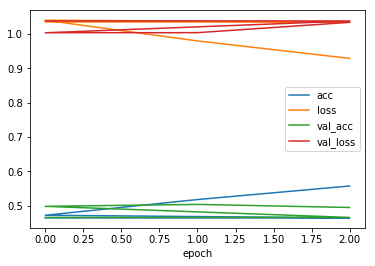

In [21]:
top_model_loss_history_df.plot(x=0)

In [22]:
# fine tune on full model
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

mobilenet_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# CREATE AN "REAL" MODEL FROM Mobilenet
# BY COPYING ALL THE LAYERS OF Mobilenet
model = Sequential()
for l in mobilenet_model.layers:
    model.add(l)


# CONCATENATE THE TWO MODELS
model.add(top_model)

# LOCK THE TOP CONV LAYERS
for layer in model.layers:
    layer.trainable = True
    print(layer.name)

# COMPILE THE MODEL
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=lr, momentum=momentum),
              metrics=['accuracy'])

model.summary()

input_2
conv1
conv1_bn
conv1_relu
conv_dw_1
conv_dw_1_bn
conv_dw_1_relu
conv_pw_1
conv_pw_1_bn
conv_pw_1_relu
conv_dw_2
conv_dw_2_bn
conv_dw_2_relu
conv_pw_2
conv_pw_2_bn
conv_pw_2_relu
conv_dw_3
conv_dw_3_bn
conv_dw_3_relu
conv_pw_3
conv_pw_3_bn
conv_pw_3_relu
conv_dw_4
conv_dw_4_bn
conv_dw_4_relu
conv_pw_4
conv_pw_4_bn
conv_pw_4_relu
conv_dw_5
conv_dw_5_bn
conv_dw_5_relu
conv_pw_5
conv_pw_5_bn
conv_pw_5_relu
conv_dw_6
conv_dw_6_bn
conv_dw_6_relu
conv_pw_6
conv_pw_6_bn
conv_pw_6_relu
conv_dw_7
conv_dw_7_bn
conv_dw_7_relu
conv_pw_7
conv_pw_7_bn
conv_pw_7_relu
conv_dw_8
conv_dw_8_bn
conv_dw_8_relu
conv_pw_8
conv_pw_8_bn
conv_pw_8_relu
conv_dw_9
conv_dw_9_bn
conv_dw_9_relu
conv_pw_9
conv_pw_9_bn
conv_pw_9_relu
conv_dw_10
conv_dw_10_bn
conv_dw_10_relu
conv_pw_10
conv_pw_10_bn
conv_pw_10_relu
conv_dw_11
conv_dw_11_bn
conv_dw_11_relu
conv_pw_11
conv_pw_11_bn
conv_pw_11_relu
conv_dw_12
conv_dw_12_bn
conv_dw_12_relu
conv_pw_12
conv_pw_12_bn
conv_pw_12_relu
conv_dw_13
conv_dw_13_bn
conv_dw_13_

In [23]:
model.load_weights(full_model_weight_path)

In [24]:
# load full mode result
npzfile = np.load(full_model_test_result)
y_true = npzfile['y_true']
y_pred = npzfile['y_pred']
log.debug(y_true.shape)
log.debug(y_pred.shape)

In [25]:
# report test accuracy
test_accuracy = 100*np.sum(np.argmax(y_pred, axis=1)==np.argmax(y_true, axis=1))/len(y_true)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 49.4882%


In [26]:
# report test accuracy on TTD
ttd_X1 = ttd_data_df.X.as_matrix()
ttd_y_pred = model.predict(paths_to_tensor(ttd_X1))
    
ttd_y_pred_two_classes=ttd_y_pred[:,[0,2]]
ttd_y_true = ttd_data_df.y.as_matrix()

In [27]:
ttd_test_accuracy = 100*np.sum(np.argmax(ttd_y_pred_two_classes, axis=1)==ttd_y_true)/len(ttd_y_true)
print('TTD Test accuracy: %.4f%%' % ttd_test_accuracy)

TTD Test accuracy: 76.4172%
